In [39]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [40]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
tf.compat.v1.enable_v2_behavior()

from sklearn.decomposition import PCA

In [41]:
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metrics
from tf_agents.policies import random_tf_policy, epsilon_greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks import actor_distribution_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import array_spec
from tf_agents.environments import utils, wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import py_driver

In [4]:
class RandomSophisticatedFunction(object):
    """A function converting an input into a high-dimensional object."""
    def __init__(self, n=10, k=100, seed=11):
        
        tf.random.set_seed(seed)
        
        self.model = tf.keras.Sequential([
            #tf.keras.layers.Dense(10, input_shape=(n,), activation='relu'),
            #tf.keras.layers.Dense(100),
            tf.keras.layers.Dense(k, bias_initializer='random_uniform'),
        ])
        
    def __call__(self, x):
        return x
        return self.model(np.array([x])).numpy()[0]
    
#assert RandomSophisticatedFunction(n=3, k=5, seed=1)([10,10,10]).shape == (5,)

In [5]:
RandomSophisticatedFunction(n=3, seed=1)([10,10,10])

[10, 10, 10]

In [6]:
class VectorIncrementEnvironment(object):
    """VectorIncrement environment."""
    def __init__(self, n=10, k=20):
        self.n = n
        self.k = k
        self.e = RandomSophisticatedFunction(n=n, k=k)
        self.s = np.zeros(self.n)

    def encoded_state(self):
        return np.array(self.e(self.s), dtype=np.float32)
        
    def reset(self):
        self.s = np.zeros(self.n)
        return self.encoded_state()

    def step(self, action):
        assert action in range(0, self.n + 1)
        
        s_old = np.copy(self.s)
        if action > 0:
            self.s[action - 1] += 1
            
            if max(s_old) - min(s_old) > 0:
                r = (max(s_old) - s_old[action - 1]) / (max(s_old) - min(s_old))
            else:
                r = 0
        else:
            r = 0
            
        #def metric(x):
        #    return max(x) - np.mean(x)
       # 
       # r = (metric(s_old) - metric(self.s)) > 0
        
        
            
        return {'reward': float(r),
               'state': np.copy(self.s),
               'observation': self.encoded_state()}
        
        
    def __repr__(self):
        return str(self.s)

In [7]:
n = 2
env = VectorIncrementEnvironment(n=n, k=10)

In [8]:
env.s

array([0., 0.])

In [9]:
env.step(2)

{'reward': 0.0,
 'state': array([0., 1.]),
 'observation': array([0., 1.], dtype=float32)}

In [10]:
env.reset()

array([0., 0.], dtype=float32)

# Testing if PCA works

In [11]:
obs = []
states = []

for _ in range(3):
    o = env.reset()
    for _ in range(50):
        a = np.random.randint(0, n + 1)
        result = env.step(a)
        obs.append(result['observation'])
        states.append(result['state'])
states = np.array(states)

In [12]:
pca = PCA(n_components=2)
pca = pca.fit_transform(obs)

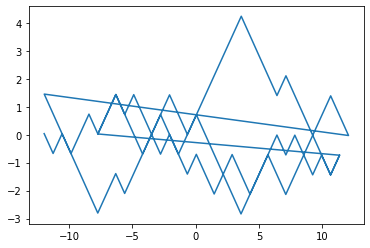

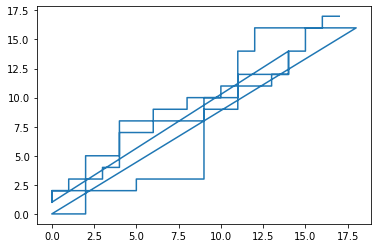

In [13]:
plt.figure()
plt.plot(pca[:, 0], pca[:, 1])
plt.show()
plt.figure()
plt.plot(states[:, 0], states[:, 1])
plt.show()

### PCA does not recover the variables we want...

The increase is NOT monotonous

# Running RL with tf.agents

In [14]:
num_iterations = 20000 # @param {type: "integer"}

initial_collect_steps = 1000 # @param {type: "integer"}
collect_steps_per_iteration = 1
replay_buffer_max_length = 1000

batch_size = 256
learning_rate = 1e-6
log_interval = 1

num_eval_episodes = 10
eval_interval = 1

In [15]:
v_n = 2
v_k = 2
v_seed = 10

In [16]:
class VectorIncrementEnvironmentTFAgents(tf_py_environment.TFPyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=v_n, name='action')
    self._observation_spec = array_spec.ArraySpec(
        shape=(v_k,), dtype=np.float32, name='observation')
    self._time_step_spec = ts.time_step_spec(self._observation_spec)
    
    self.env = VectorIncrementEnvironment(n=v_n, k=v_k)
    self._state = self.env.encoded_state()
    self._episode_ended = False
    self._batched = False
   # self._batch_size = None
    
  def batch_size(self):
    return None

  @property
  def batched(self):
    return False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self.env.reset()
    self._state = self.env.encoded_state()
    self._episode_ended = False
    return ts.restart(self._state)

  def _step(self, action):

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    res = self.env.step(action)
    self._state = self.env.encoded_state()

    return ts.transition(self._state, reward=res['reward'], discount=1.0)


In [17]:
# checking that the environment works
env = VectorIncrementEnvironmentTFAgents()
env = wrappers.TimeLimit(env, 20)
utils.validate_py_environment(env, episodes=5)

In [18]:
train_env = tf_py_environment.TFPyEnvironment(env)
#train_env = env

In [19]:
fc_layer_params = ()

actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [20]:
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)

agent.initialize()

In [21]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [22]:
num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
avg_return = tf_metrics.AverageReturnMetric()
act_hist = tf_metrics.ChosenActionHistogram()

observers = [num_episodes, env_steps, avg_return, replay_buffer.add_batch, act_hist]

#tf_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(agent.collect_policy, 0.5)

tf_env = train_env
tf_policy = agent.collect_policy

driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=batch_size)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())

final_time_step TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>)
Number of Steps:  5120
Number of Episodes:  256


In [23]:
avg_return.result()

<tf.Tensor: shape=(), dtype=float32, numpy=3.1>

In [24]:
act_hist.result()

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 2, 2, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0,
       1, 0, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 2,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int32)>

In [25]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

In [26]:
### (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

returns = []

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  # Continue running from previous state
  final_time_step, _ = driver.run(final_time_step, policy_state)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    ret = avg_return.result()
    print('step = {0}: Average Return = {1}'.format(step, ret))
    avg_return.reset()
    returns.append(ret)

step = 1: loss = -0.10251066833734512
step = 1: Average Return = 1.399999976158142
step = 2: loss = 0.06175588071346283
step = 2: Average Return = 2.9000000953674316
step = 3: loss = -0.08284898102283478
step = 3: Average Return = 2.0
step = 4: loss = -0.032438769936561584
step = 4: Average Return = 2.5
step = 5: loss = -0.11647597700357437
step = 5: Average Return = 2.799999952316284
step = 6: loss = -0.026650317013263702
step = 6: Average Return = 2.299999952316284
step = 7: loss = -0.13854394853115082
step = 7: Average Return = 3.0999999046325684
step = 8: loss = -0.2047019898891449
step = 8: Average Return = 2.0
step = 9: loss = -0.21091753244400024
step = 9: Average Return = 2.0999999046325684
step = 10: loss = -0.17106138169765472
step = 10: Average Return = 2.4000000953674316
step = 11: loss = -0.2307930439710617
step = 11: Average Return = 2.5
step = 12: loss = -0.24493372440338135
step = 12: Average Return = 2.5999999046325684
step = 13: loss = -0.20282140374183655
step = 13: 

step = 101: loss = 0.877232015132904
step = 101: Average Return = 2.299999952316284
step = 102: loss = -0.21059338748455048
step = 102: Average Return = 1.100000023841858
step = 103: loss = 0.5249655842781067
step = 103: Average Return = 1.7999999523162842
step = 104: loss = -0.39098355174064636
step = 104: Average Return = 2.200000047683716
step = 105: loss = 0.47442224621772766
step = 105: Average Return = 2.4000000953674316
step = 106: loss = 0.5690268278121948
step = 106: Average Return = 2.0999999046325684
step = 107: loss = -0.2981124222278595
step = 107: Average Return = 2.4000000953674316
step = 108: loss = -0.2437858134508133
step = 108: Average Return = 2.5999999046325684
step = 109: loss = -0.03488420322537422
step = 109: Average Return = 1.7999999523162842
step = 110: loss = 0.9074254631996155
step = 110: Average Return = 2.4000000953674316
step = 111: loss = 0.21143081784248352
step = 111: Average Return = 1.7999999523162842
step = 112: loss = 0.4027245044708252
step = 112

step = 200: loss = 0.06298810243606567
step = 200: Average Return = 2.5
step = 201: loss = 0.027693001553416252
step = 201: Average Return = 3.200000047683716
step = 202: loss = -0.2636941373348236
step = 202: Average Return = 2.0999999046325684
step = 203: loss = -0.350010484457016
step = 203: Average Return = 2.0999999046325684
step = 204: loss = -0.2175421416759491
step = 204: Average Return = 2.799999952316284
step = 205: loss = -0.19618768990039825
step = 205: Average Return = 2.299999952316284
step = 206: loss = 0.7408574819564819
step = 206: Average Return = 2.5
step = 207: loss = 1.2609002590179443
step = 207: Average Return = 2.5999999046325684
step = 208: loss = -0.22953437268733978
step = 208: Average Return = 1.600000023841858
step = 209: loss = -0.06604819744825363
step = 209: Average Return = 3.0999999046325684
step = 210: loss = -0.12434585392475128
step = 210: Average Return = 2.5
step = 211: loss = 1.14372718334198
step = 211: Average Return = 2.5999999046325684
step =

step = 298: loss = -0.031154461205005646
step = 298: Average Return = 2.0
step = 299: loss = -0.29899272322654724
step = 299: Average Return = 1.399999976158142
step = 300: loss = -0.24796976149082184
step = 300: Average Return = 2.4000000953674316
step = 301: loss = 0.11503595858812332
step = 301: Average Return = 2.700000047683716
step = 302: loss = -0.19142764806747437
step = 302: Average Return = 1.5
step = 303: loss = 0.04638564586639404
step = 303: Average Return = 2.299999952316284
step = 304: loss = -0.04707406833767891
step = 304: Average Return = 2.5999999046325684
step = 305: loss = -0.27107328176498413
step = 305: Average Return = 1.7000000476837158
step = 306: loss = -0.24134045839309692
step = 306: Average Return = 1.7999999523162842
step = 307: loss = -0.4197739064693451
step = 307: Average Return = 2.299999952316284
step = 308: loss = 0.436305969953537
step = 308: Average Return = 2.0999999046325684
step = 309: loss = -0.24880246818065643
step = 309: Average Return = 2.

KeyboardInterrupt: 

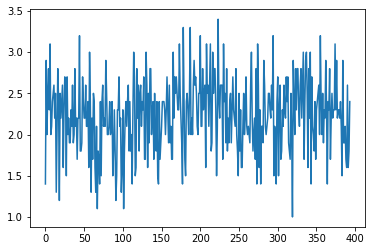

In [27]:
plt.plot(returns)

In [28]:
replay_buffer.clear()

In [29]:
num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
avg_return = tf_metrics.AverageReturnMetric()
act_hist = tf_metrics.ChosenActionHistogram()

observers = [num_episodes, env_steps, avg_return, replay_buffer.add_batch, act_hist]

#tf_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(agent.collect_policy, 0.5)

tf_env = train_env
tf_policy = agent.policy

driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=batch_size)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())

final_time_step TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>)
Number of Steps:  5120
Number of Episodes:  256


In [30]:
avg_return.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [31]:
for r in replay_buffer.gather_all().observation[:10].numpy()[0]:
    print(r)

[8. 0.]
[9. 0.]
[10.  0.]
[11.  0.]
[12.  0.]
[13.  0.]
[14.  0.]
[15.  0.]
[16.  0.]
[17.  0.]
[18.  0.]
[19.  0.]
[20.  0.]
[0. 0.]
[1. 0.]
[2. 0.]
[3. 0.]
[4. 0.]
[5. 0.]
[6. 0.]
[7. 0.]
[8. 0.]
[9. 0.]
[10.  0.]
[11.  0.]
[12.  0.]
[13.  0.]
[14.  0.]
[15.  0.]
[16.  0.]
[17.  0.]
[18.  0.]
[19.  0.]
[20.  0.]
[0. 0.]
[1. 0.]
[2. 0.]
[3. 0.]
[4. 0.]
[5. 0.]
[6. 0.]
[7. 0.]
[8. 0.]
[9. 0.]
[10.  0.]
[11.  0.]
[12.  0.]
[13.  0.]
[14.  0.]
[15.  0.]
[16.  0.]
[17.  0.]
[18.  0.]
[19.  0.]
[20.  0.]
[0. 0.]
[1. 0.]
[2. 0.]
[3. 0.]
[4. 0.]
[5. 0.]
[6. 0.]
[7. 0.]
[8. 0.]
[9. 0.]
[10.  0.]
[11.  0.]
[12.  0.]
[13.  0.]
[14.  0.]
[15.  0.]
[16.  0.]
[17.  0.]
[18.  0.]
[19.  0.]
[20.  0.]
[0. 0.]
[1. 0.]
[2. 0.]
[3. 0.]
[4. 0.]
[5. 0.]
[6. 0.]
[7. 0.]
[8. 0.]
[9. 0.]
[10.  0.]
[11.  0.]
[12.  0.]
[13.  0.]
[14.  0.]
[15.  0.]
[16.  0.]
[17.  0.]
[18.  0.]
[19.  0.]
[20.  0.]
[0. 0.]
[1. 0.]
[2. 0.]
[3. 0.]
[4. 0.]
[5. 0.]
[6. 0.]
[7. 0.]
[8. 0.]
[9. 0.]
[10.  0.]
[11.  0.]
[12.  0.]
[13.

In [32]:
xy = replay_buffer.gather_all().observation.numpy()[0]

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

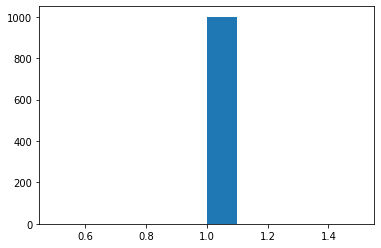

In [33]:
plt.hist(replay_buffer.gather_all().action.numpy()[0])

In [34]:
replay_buffer.gather_all().action.numpy().shape

(1, 1000)

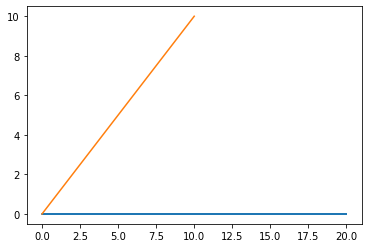

In [35]:
plt.plot(xy[:, 0], xy[:, 1])
plt.plot([0, 10], [0, 10])

# Hardcoded agent

In [ ]:
o = train_env.reset().observation.numpy()[0]
total_reward = 0
while True:
    act = 2 if o[0] > o[1] else 1
    step = train_env.step(act)
    o = step.observation.numpy()[0]
    r = np.array(step.reward[0])
    total_reward += r
    print(act, o, r)
    if step.step_type == 2:
        break
print(total_reward)

SGD/Adam on 2x2 or 2x5 doesn't work with many learning rates with or without preproc

1. look at the replay buffer
2. make the env simpler (1 action -> reward, another -> no reward) and see if PG converges and gradually increase its complexity
3. use SGD and vanilla PG
* try without tf agents -- try openai baselines or a handcoded version

In [38]:
a = np.array([1,2,3])
b = np.array(a)
a[0]=4
b

array([1, 2, 3])